In [1]:
import IPython
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Conv1D,  MaxPooling1D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import pandas as pd 
import csv


On récupère les sets d'entrainement que l'on split pour avoir un set de train et un set de validation

In [2]:
x_train=np.load('x_train.npy')
y_train=np.load('y_train.npy')

val_nb=int(x_train.shape[0]*0.7)
x_t=x_train[:val_nb]
x_v=x_train[val_nb:]
y_t=y_train[:val_nb]
y_v=y_train[val_nb:]
x_t = x_t.reshape(x_t.shape[0],x_t.shape[1],x_t.shape[2], 1)
x_v = x_v.reshape(x_v.shape[0],x_v.shape[1],x_v.shape[2], 1)
y_t = y_t.reshape(y_t.shape[0], 1)
y_v = y_v.reshape(y_v.shape[0], 1)

On definit ici un 1er modèle, lourd puisqu'il possède environ 30 millions de paramètres. On s'est inspiré des VGG16 vu en cours.

In [3]:
model = Sequential(name="Modele_initial")

model.add(Conv2D(64, 1,activation="relu",input_shape=(x_t.shape[1::])))
model.add(Conv2D(64, 1,activation="relu"))
model.add(MaxPooling2D((2,2),strides=(2,2)))

model.add(Conv2D(128, 1,activation="relu"))
model.add(Conv2D(128, 1,activation="relu"))
model.add(MaxPooling2D((2,2),strides=(2,2)))

model.add(Conv2D(256, 1,activation="relu"))
model.add(Conv2D(256, 1,activation="relu"))
model.add(Conv2D(256, 1,activation="relu"))
model.add(MaxPooling2D((2,2),strides=(2,2)))


model.add(Flatten())
model.add(Dense(4096,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2048,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation="relu"))



model.summary()

Model: "Modele_initial"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        128       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        4160      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       8320      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       16512     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                

On compile le modèle avec un optimizer Adam et une erreur carrée moyenne pour la loss. On fit ensuite le modèle.

In [4]:
from tensorflow.keras.optimizers import SGD

### START CODE HERE ###
batch_size = 512
epochs = 20
learning_rate = 0.1

model.compile(optimizer="Adam",loss='mse')

output = model.fit(x_t, y_t,epochs=epochs, batch_size=batch_size,validation_data=(x_v,y_v))

Epoch 1/20
64/64 [==============================] - 51s 796ms/step - loss: 13.3967 - val_loss: 0.1563
Epoch 2/20
64/64 [==============================] - 49s 768ms/step - loss: 1.0190 - val_loss: 0.0895
Epoch 3/20
64/64 [==============================] - 54s 843ms/step - loss: 0.9145 - val_loss: 0.0261
Epoch 4/20
64/64 [==============================] - 53s 823ms/step - loss: 0.8305 - val_loss: 0.0274
Epoch 5/20
64/64 [==============================] - 51s 791ms/step - loss: 0.8229 - val_loss: 0.0810
Epoch 6/20
64/64 [==============================] - 51s 797ms/step - loss: 0.8462 - val_loss: 0.0229
Epoch 7/20
64/64 [==============================] - 53s 832ms/step - loss: 0.8065 - val_loss: 0.0531
Epoch 8/20
64/64 [==============================] - 51s 792ms/step - loss: 0.7553 - val_loss: 0.0359
Epoch 9/20
64/64 [==============================] - 51s 804ms/step - loss: 0.7557 - val_loss: 0.0780
Epoch 10/20
64/64 [==============================] - 52s 817ms/step - loss: 0.7443 - val_l

Ici on predit le train set pour pouvoir comparer la prédiction avec la sortie connue du train set y_train.

In [5]:
y_pred=model.predict(x_t)


On plot la performance du training et de la validation.

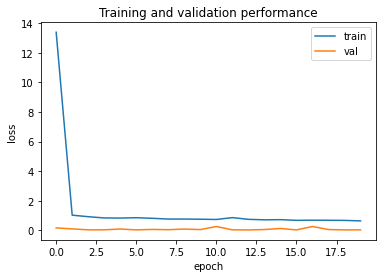

In [6]:
# Plotting the performance of the network
plt.plot(output.epoch, output.history['loss'], label='train')
plt.plot(output.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

On calcule la précision. Puisqu'on est en mse, on decide de jouer sur une erreur epsilon. En voyant que les valeurs oscillent entre 14 et 16, on choisi un epsilon cohérent. Sur une marge d'erreur de 0.2, nous obtenons une précision de 81% ce qui est acceptable pour la range de valeurs.

In [41]:
print("PRECISION SUR LE TRAIN")
for j in range(0,6):
    p=0
    epsilon=2*10**-j
    for i in range(len(y_pred)):
        if np.abs(y_pred[i]-y_t[i])<epsilon:
            p=p+1
    precision=p/len(y_pred)*100
    print ("Precision à 2*10e-{} : {}%".format(j, round(precision,2)))

PRECISION SUR LE TRAIN
Precision à 2*10e-0 : 100.0%
Precision à 2*10e-1 : 81.26%
Precision à 2*10e-2 : 7.04%
Precision à 2*10e-3 : 0.67%
Precision à 2*10e-4 : 0.09%
Precision à 2*10e-5 : 0.0%


Nous répétons le même principe que précedemment mais sur le set de validation.

In [15]:
y_predval=model.predict(x_v)

In [42]:
print("PRECISION SUR LA VALIDATION")
for j in range(0,6):
    p=0
    epsilon=2*10**-j
    for i in range(len(y_predval)):
        if np.abs(y_predval[i]-y_v[i])<epsilon:
            p=p+1
    precision=p/len(y_predval)*100
    print ("Precision à 2*10e-{} : {}%".format(j, round(precision,2)))

PRECISION SUR LA VALIDATION
Precision à 2*10e-0 : 100.0%
Precision à 2*10e-1 : 82.03%
Precision à 2*10e-2 : 6.9%
Precision à 2*10e-3 : 0.62%
Precision à 2*10e-4 : 0.04%
Precision à 2*10e-5 : 0.0%


Notre modèle initial etant assez lourd, nous décidons de créer un modèle reduit pour chercher une performance similaire avec un coût de ressources moins élevé. La structure et les fit/compile reste identique au modèle précédent, seuls les paramètres et le nombres de couches seront modifiés.

In [8]:
model2 = Sequential(name="Modele_reduit")

model2.add(Conv2D(4, 1,activation="relu",input_shape=(x_t.shape[1::])))
model2.add(Conv2D(4, 1,activation="relu"))
model2.add(MaxPooling2D((2,2),strides=(2,2)))

model2.add(Conv2D(8, 1,activation="relu"))
model2.add(Conv2D(8, 1,activation="relu"))
model2.add(MaxPooling2D((2,2),strides=(2,2)))

model2.add(Conv2D(12, 1,activation="relu"))
model2.add(Conv2D(12, 1,activation="relu"))
model2.add(Conv2D(12, 1,activation="relu"))
model2.add(MaxPooling2D((2,2),strides=(2,2)))


model2.add(Flatten())
model2.add(Dense(192,activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(96,activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(48,activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(1,activation="relu"))



model2.summary()

Model: "Modele_reduit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 32, 32, 4)         8         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 4)         20        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 4)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 8)         40        
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 8)         72        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 8)          0         
 2D)                                                 

In [9]:
model2.compile(optimizer="Adam",loss='mse')

output2 = model2.fit(x_t, y_t,epochs=20, batch_size=batch_size,validation_data=(x_v,y_v))

Epoch 1/20
64/64 [==============================] - 3s 39ms/step - loss: 86.2902 - val_loss: 0.7896
Epoch 2/20
64/64 [==============================] - 2s 35ms/step - loss: 16.9894 - val_loss: 0.9227
Epoch 3/20
64/64 [==============================] - 2s 36ms/step - loss: 13.6412 - val_loss: 0.9794
Epoch 4/20
64/64 [==============================] - 2s 36ms/step - loss: 12.4281 - val_loss: 0.6259
Epoch 5/20
64/64 [==============================] - 2s 35ms/step - loss: 11.9246 - val_loss: 0.6008
Epoch 6/20
64/64 [==============================] - 2s 36ms/step - loss: 11.3398 - val_loss: 0.7653
Epoch 7/20
64/64 [==============================] - 2s 37ms/step - loss: 11.0627 - val_loss: 0.7167
Epoch 8/20
64/64 [==============================] - 2s 37ms/step - loss: 10.7116 - val_loss: 0.3912
Epoch 9/20
64/64 [==============================] - 2s 35ms/step - loss: 10.5077 - val_loss: 0.7307
Epoch 10/20
64/64 [==============================] - 2s 38ms/step - loss: 10.0354 - val_loss: 0.5565

In [10]:
y_pred2=model2.predict(x_t)

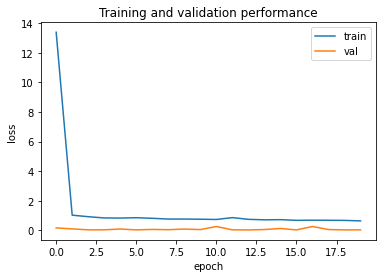

In [11]:
# Plotting the performance of the network
plt.plot(output2.epoch, output.history['loss'], label='train')
plt.plot(output2.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

In [24]:
for j in range(0,6):
    p=0
    epsilon=5*10**-j
    for i in range(len(y_pred2)):
        if np.abs(y_pred2[i]-y_t[i])<epsilon:
            p=p+1
    precision=p/len(y_pred2)*100
    print ("Precision à 5*10e-{} : {}%".format(j, round(precision,2)))

Precision à 5*10e-0 : 100.0%
Precision à 5*10e-1 : 63.88%
Precision à 5*10e-2 : 0.0%
Precision à 5*10e-3 : 0.0%
Precision à 5*10e-4 : 0.0%
Precision à 5*10e-5 : 0.0%


In [33]:
y_predval2=model2.predict(x_v)

In [37]:
for j in range(0,6):
    p=0
    epsilon=5*10**-j
    for i in range(len(y_predval2)):
        if np.abs(y_predval2[i]-y_v[i])<epsilon:
            p=p+1
    precision=p/len(y_predval2)*100
    print ("Precision à 5*10e-{} : {}%".format(j, round(precision,2)))

Precision à 5*10e-0 : 100.0%
Precision à 5*10e-1 : 64.28%
Precision à 5*10e-2 : 0.0%
Precision à 5*10e-3 : 0.0%
Precision à 5*10e-4 : 0.0%
Precision à 5*10e-5 : 0.0%


Sur notre modèle reduit, on obtient une precision acceptable de 64% pour une valeur d'épsilon de 0.5. Cependant sachant que la range de notre sortie est de 1.5, cette précision n'est que peu pertinante et ne permets pas d'évaluer la performance de notre modèle sur un tel dataset.
Finalement, malgré sa lourdeur, notre modèle initial reste plus performant et nous choisiront ce modèle comme notre modèle final.